# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'
plt.style.use('ggplot')
import astropy.units as u
import astropy.constants as const
import ipywidgets as widgets
import ipywidgets
from IPython.display import clear_output

import utils
from kernel_nuller import KN0

# 🎛️ Parameters

In [2]:
#==============================================================================
# Direct simulation parameters
#==============================================================================

# Wavelength
l = 1.65e-6 * u.m

# Telescopes positions
telescope_positions = np.array([
    [0, 0],
    [1, 1],
    [2, 1.5],
    [3, 0.7],
]) * 42.2 * u.m

# Contrast
contrast = 1e-0

# Angular spearation
theta = 5e-3 * u.arcsec

# Baseline rotation
alpha = 15 * u.deg

#==============================================================================
# Analysis parameters
#==============================================================================

# Contrast range
contrast_range = np.logspace(-10, 0, 10)

# Angular separation range
theta_range = np.linspace(0, 1e-2, 100) * u.arcsec

# Baseline rotation range
alpha_range = np.linspace(0, 360, 100) * u.deg

# 📡 Telescope position

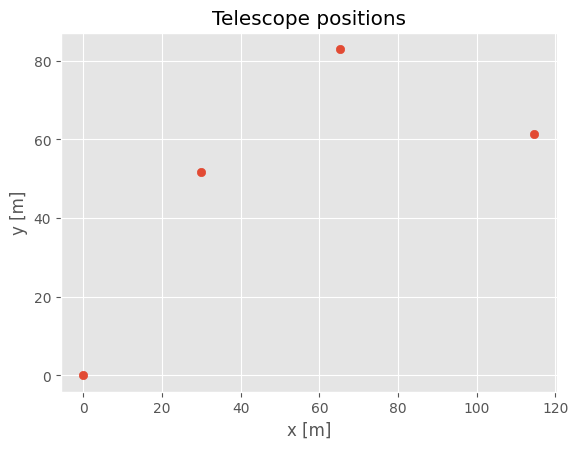

In [3]:
# Compute position telescope with rotated baseline

def rotate_baseline(telescope_positions, alpha):
    real_telescope_positions = np.empty_like(telescope_positions)
    for i in range(telescope_positions.shape[0]):
        x = telescope_positions[i][0].to(u.m).value
        y = telescope_positions[i][1].to(u.m).value
        a = alpha.to(u.rad).value

        x2 = x * np.cos(a) - y * np.sin(a)
        y2 = x * np.sin(a) + y * np.cos(a)

        real_telescope_positions[i] = [x2, y2] * u.m
    return real_telescope_positions
real_telescope_positions = rotate_baseline(telescope_positions, alpha)

# Plot telescope positions

fig, ax = plt.subplots()
ax.scatter(real_telescope_positions[:, 0], real_telescope_positions[:, 1])
ax.set_aspect('equal')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Telescope positions')
plt.show()

---

# 🎯 Goal

We aim to detect make direct detection of exoplanets. There is two main challenges to achieve this goal:
- The **contrast**: the exoplanet is much fainter than the star it orbits. The contrast is typically of the order of $10^{-6}$ to $10^{-10}$.
- The **angular separation**: the exoplanet is very close to the star. The angular separation depend on the distance of the exoplanet to the star and the distance of the star to the observer and can easily goes below the arcsecond.

# 🔎 Detection methods

It exist several methods to detect exoplanets. The most common are:
- **Radial velocity method**: the exoplanet induce a wobble in the star it orbits. This wobble can be detected by the Doppler effect (the light is alternatively redshifted and blueshifted).
- **Transit method**: the exoplanet pass in front of the star and block a fraction of the light. This fraction can be detected by the decrease of the star luminosity.
- **Microlensing**: the exoplanet act as a lens and magnify the light of a background star. This magnification can be detected by the increase of the star luminosity.
- **Astrometry**: the exoplanet induce a wobble in the star it orbits. This wobble can be detected by the change of the star position.
- **Coronography**: the exoplanet is directly imaged. This is the most challenging method because of the contrast and the angular separation.

<div align=center>
<img src="../img/detection_methods.jpg" width=500px>
<p><i>Paul Anthony Wilson - Exoplanet detection techniques</i><p>
</div>

Until now, the coronography was the only method allowing direct detection. But it has two main limitations:
- It require huge telescopes in order to have a good angular resolution.
- The contrast we can achieve is limited by unperfect fabrication process of the optical components which lead to undesired diffraction effects.

# 🔆 Signal nature

The star and the planet are point sources. Seen from a classical telescope, it will result in an image made of the objects convolution with the point spread function (PSF) of the telescope.

$$
I = O \otimes PSF
$$

Here we consider the most simple PSF : the Airy disk. The Airy disk is the diffraction pattern of a point source by a circular aperture. It is given by:

$$
PSF = \left(\frac{2J_1(x)}{x}\right)^2
$$

where $J_1$ is the Bessel function of the first kind of order 1 and $x = \frac{2\pi r}{\lambda f}$ is the normalized radius of the Airy disk.

Then, we focus the image in a monomode optical fiber which will basically only keep the main lobe of the PSF and reshape it in a Gaussian form. In this process, we lose the spatial information so we have no longer images, but the light flux of each object in the fiber can be simply described by a complex number.

> I don't understand very well the physical process behing this injection in a monomode fiber. I need to dig into that.

Using this formalism, the light flux of the star and the planet can  be described by only 2 complex numbers for each telescope, giving the amplitude and phase of each object.

In [4]:
# Input beams

star_light = 1+0j
planet_light = star_light * contrast

def acquire_signals(light, angle, wavelenght, telescope_positions):
    acquired_signals = np.empty(telescope_positions.shape[0], dtype=complex)
    for i, p in enumerate(telescope_positions):
        introduced_phase = 2 * np.pi * p[0] * np.sin(angle) / wavelenght
        acquired_signals[i] = light * np.exp(1j * introduced_phase)
    return acquired_signals

star_signals = acquire_signals(star_light, 0, l, real_telescope_positions)
planet_signals = acquire_signals(planet_light, theta, l, real_telescope_positions)

def signals_as_str(signals):
    res = ""
    for i, s in enumerate(signals):
        res += f" - Telescope {i}: {np.abs(s):.2e} * exp(i * {np.angle(s):.2f} * pi)\n"
    return res[:-1]

print(f"Star signals:\n{signals_as_str(star_signals)}")
print(f"Planet signals:\n{signals_as_str(planet_signals)}")

Star signals:
 - Telescope 0: 1.00e+00 * exp(i * 0.00 * pi)
 - Telescope 1: 1.00e+00 * exp(i * 0.00 * pi)
 - Telescope 2: 1.00e+00 * exp(i * 0.00 * pi)
 - Telescope 3: 1.00e+00 * exp(i * 0.00 * pi)
Planet signals:
 - Telescope 0: 1.00e+00 * exp(i * 0.00 * pi)
 - Telescope 1: 1.00e+00 * exp(i * 2.75 * pi)
 - Telescope 2: 1.00e+00 * exp(i * -0.27 * pi)
 - Telescope 3: 1.00e+00 * exp(i * -1.98 * pi)


# ➖ Nulling

This is where the Nulling technic come into play. The idea is to use two several telescopes and take advantage of destructives interferances to cancel the star light and using the fact that the planet is not perfectly in the line of sight, which will lead to an unperfect destructive interference, or in best scenarios, on constructive ones! This is a very challenging technic because it is highly phase sensitive and require a very good control of the optical path.

<div align=center>
<img src="../img/nulling_principle.jpg" width=400px>
</div>

In [5]:
def nuller_2x2(beams:np.array) -> np.array:
    """
    Simulate a 2 input beam nuller.

    Parameters
    ----------
    - `beams` : Array of 2 input beams complex amplitudes

    Returns
    -------
    - Array of 2 output beams complex amplitudes
        - 1st output is the bright channel
        - 2nd output is the dark channel
    """

    # Input checks
    try:
        beams = np.array(beams, dtype=complex)
    except:
        raise TypeError(f"'beams' must be an array-like object containing complex-convertible numbers, got {type(beams)}")
    if beams.shape != (2,):
        raise ValueError(f"'beams' must have shape (2,), got {beams.shape}")

    # Nuller matrix
    N = 1/np.sqrt(2) * np.array([
        [1,   1],
        [1,  -1],
    ])

    # Operation
    return N @ beams

def nuller_4x4(beams:np.array) -> np.array:
    """
    Simulate a 4 input beam nuller.

    Parameters
    ----------
    - `beams` : Array of 4 input beams complex amplitudes

    Returns
    -------
    - Array of 2 output beams complex amplitudes
        - 1st output is the bright channel
        - 2nd output is the dark channel
    """

    # Input checks
    try:
        beams = np.array(beams, dtype=complex)
    except:
        raise TypeError(f"'beams' must be an array-like object containing complex-convertible numbers, got {type(beams)}")
    if beams.shape != (4,):
        raise ValueError(f"'beams' must have shape (4,), got {beams.shape}")

    # Dispatch the beams to the 2x2 nullers
    N1_output = nuller_2x2(beams[:2])
    N2_output = nuller_2x2(beams[2:])
    N3_output = nuller_2x2(np.array([N1_output[0], N2_output[0]]))
    N4_output = nuller_2x2(np.array([N1_output[1], N2_output[1]]))
                           
    return np.concatenate([N3_output, N4_output])

# 💠 Kernel

One propose the following architecture:

<img src="../img/components.png" width=1000px>

The idea of the kernel is to modify this trasmission map in an asymetric way in order to be able to constrain the planet position to only one location.

> TO COMPLETE

In [6]:
def splitmix_2x2(beams:np.array, theta:float=np.pi/2) -> np.array:
    """
    Simulate a 2 input beam split and mix.

    Parameters
    ----------
    - `beams` : Array of 2 input beams complex amplitudes
    - `theta` : Phase shift between the two output beams

    Returns
    -------
    - Array of 2 output beams complex amplitudes
    """

    # Input checks
    try:
        beams = np.array(beams, dtype=complex)
    except:
        raise TypeError(f"'beams' must be an array-like object containing complex-convertible numbers, got {type(beams)}")
    if beams.shape != (2,):
        raise ValueError(f"'beams' must have shape (2,), got {beams.shape}")

    # Splitter matrix
    S = 1/np.sqrt(2) * np.array([
        [np.exp(1j*theta/2), np.exp(-1j*theta/2)],
        [np.exp(-1j*theta/2), np.exp(1j*theta/2)]
    ])

    # Operation
    return S @ beams

def splitmix_3x6(beams:np.array, theta:float=np.pi/2) -> np.array:
    """
    Simulate a 4 input beam split and mix.

    Parameters
    ----------
    - `beams` : Array of 4 input beams complex amplitudes
    - `theta` : Phase shift between the two output beams

    Returns
    -------
    - Array of 6 output beams complex amplitudes
    """

    # Input checks
    try:
        beams = np.array(beams, dtype=complex)
    except:
        raise TypeError(f"'beams' must be an array-like object containing complex-convertible numbers, got {type(beams)}")
    if beams.shape != (3,):
        raise ValueError(f"'beams' must have shape (3,), got {beams.shape}")

    # Dispatch the beams over the 3 split&mix
    S1_output = splitmix_2x2([beams[0], beams[1]])
    S2_output = splitmix_2x2([beams[0], beams[2]])
    S3_output = splitmix_2x2([beams[1], beams[2]])

    return np.concatenate([S1_output, S2_output, S3_output])

# 🗺️ Transmission maps

The nulling technic with two telescope show a limitation: if the planet light arrive on the two telescopes with a phase shift of $2n\pi$, the light will also be cancelled. It result in a comb-shaped transmission map, perpendicular to the baseline (there is clear bands where it's optimal to detect the planet and black bands where we will mostly destroy the planet light).

The idea of Bracewell was to rotate the baseline in order to let the planet pass through the clear bands at some point. After an entire rotation of the baseline, we will have a sinusoidal signal from which the frequency will indicate us the distance of the planet to it's star, and the phase will give us a clue about the angle between the axes star-planet and the axes of the baseline. Thus, as the transmission map is symmetric, we can constrain the planet position to 2 possible locations, on both sides of the star.

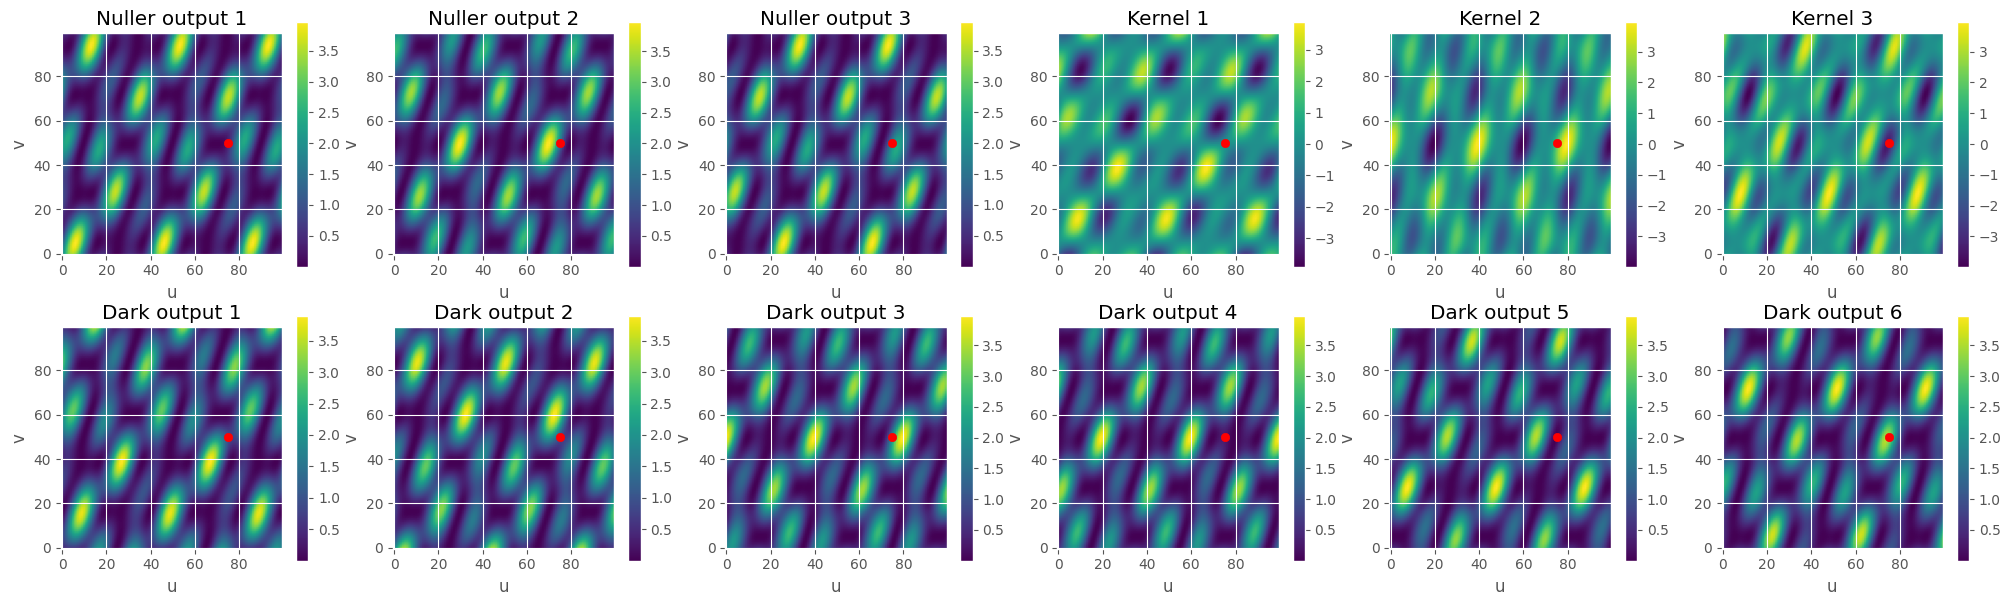

In [7]:
def plot_kernel_maps():
    global theta

    resolution = 100

    nuller_transmission_maps = np.zeros((3, resolution, resolution), dtype=complex)
    dark_transmission_maps = np.zeros((6, resolution, resolution), dtype=complex)
    kernel_transmission_maps = np.zeros((3, resolution, resolution), dtype=float)

    X, Y = np.meshgrid(np.linspace(-1, 1, resolution), np.linspace(-1, 1, resolution))
    theta_map = (theta_range[0] + np.sqrt(X**2 + Y**2) * (theta_range[-1] - theta_range[0]))
    alpha_range = np.arctan2(Y, X) * u.rad

    for x in range(resolution):
        for y in range(resolution):
            new_theta = theta_map[x, y]
            new_alpha = alpha_range[x, y]
            new_telescope_positions = rotate_baseline(telescope_positions, new_alpha)
            signals = acquire_signals(star_light, new_theta, l, new_telescope_positions)
            
            nuller_outputs = nuller_4x4(signals)
            dark_outputs = splitmix_3x6(nuller_outputs[1:])

            for i in range(3):
                nuller_transmission_maps[i, x, y] = nuller_outputs[i+1]
            
            for i in range(6):
                dark_transmission_maps[i, x, y] = dark_outputs[i]

            for i in range(3):
                kernel_transmission_maps[i, x, y] = np.abs(dark_outputs[2*i])**2 - np.abs(dark_outputs[2*i+1])**2
    
    theta_as_x = (theta - theta_range[0]) / (theta_range[-1] - theta_range[0])

    _, axs = plt.subplots(2, 6, figsize=(25, 7))
    
    for i in range(3):
        im = axs[0,i].imshow(np.abs(nuller_transmission_maps[i])**2, aspect='equal')
        axs[0,i].set_title(f"Nuller output {i+1}")
        axs[0,i].set_xlabel('u')
        axs[0,i].set_ylabel('v')
        plt.colorbar(im, ax=axs[0,i])
        axs[0,i].scatter((theta_as_x/2+0.5)*resolution, 0.5*resolution, color='red')

    for i in range(6):
        im = axs[1,i].imshow(np.abs(dark_transmission_maps[i])**2, aspect='equal')
        axs[1,i].set_title(f"Dark output {i+1}")
        axs[1,i].set_xlabel('u')
        axs[1,i].set_ylabel('v')
        axs[1,i].set_aspect('equal')
        plt.colorbar(im, ax=axs[1,i])
        axs[1,i].scatter((theta_as_x/2+0.5)*resolution, 0.5*resolution, color='red')

    for i in range(3):
        im = axs[0,i+3].imshow(kernel_transmission_maps[i], aspect='equal')
        axs[0,i+3].set_title(f"Kernel {i+1}")
        axs[0,i+3].set_xlabel('u')
        axs[0,i+3].set_ylabel('v')
        plt.colorbar(im, ax=axs[0,i+3])
        axs[0,i+3].scatter((theta_as_x/2+0.5)*resolution, 0.5*resolution, color='red')
    
    plt.show()

plot_kernel_maps()

In [8]:
kn0 = KN0(
    shifters_offset=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    input_phase_rms=1,
    inner_phase_rms=1
)

# 🫳 Manual shift controls

In [9]:
# max_power = 1
# step = 1e-20

# # Build sliders
# P_sliders = [widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description=f"P{i+1}") for i in range(14)]

# bright, darks, intermediate = kn0(star_light)

# def beam_repr(beam:complex) -> str:
#     return f"{np.abs(beam):.3e} * exp({np.angle(beam)/np.pi:.3e} pi i)"   

# inputs = [widgets.Label(value=f" ") for _ in range(4)]
# first_nuller_layer = [widgets.Label(value=f" ") for _ in range(4)]
# second_nuller_layer = [widgets.Label(value=f" ") for _ in range(4)]
# outputs = [widgets.Label(value=f" ") for _ in range(7)]

# def update_gui(*args):

#     kn0.shift_powers = np.array([x.value for x in P_sliders])

#     bright, darks, inter = kn0(star_light)

#     for i, beam in enumerate(inter['inputs']):
#         inputs[i].value = f"Input {i+1}: {beam_repr(beam)}"

#     for i, beam in enumerate(inter['first_nuller_layer']):
#         first_nuller_layer[i].value = f"N{i//2+1} : {i%2}: {beam_repr(beam)}"

#     for i, beam in enumerate(inter['second_nuller_layer']):
#         second_nuller_layer[i].value = f"N{i//2+3} : {i%2}: {beam_repr(beam)}"

#     outputs[0].value = f"Bright : {beam_repr(bright)}"
#     for i, beam in enumerate(darks): 
#         outputs[i+1].value = f"Dark {i+1}: {beam_repr(beam)}"

#     return bright, darks


# for widget in P_sliders:
#     widget.observe(update_gui, 'value')

# empty = widgets.Label()

# vbox = widgets.VBox([
#     *[widgets.HBox([x]) for x in inputs],

#     widgets.Label("1st nuller layer phase corrective powers:"),
#     widgets.HBox(P_sliders[:4]),

#     *[widgets.HBox([x]) for x in first_nuller_layer],

#     widgets.Label("2nd nuller layer phase corrective powers:"),
#     widgets.HBox(P_sliders[4:8]),
    
#     *[widgets.HBox([x]) for x in second_nuller_layer],

#     widgets.Label("Split & Mix phase corrective powers:"),
#     widgets.HBox(P_sliders[8:11]),
#     widgets.HBox(P_sliders[11:14]),

#     *[widgets.HBox([x]) for x in outputs],
# ])

# update_gui()
# vbox

# 📉 Optimization process

In [10]:
optimized_parameters, history = kn0.optimize(star_light, verbose=False)

bright_evol, dark_symmetry_evol, shifts_evol = history["bright"], history["symmetry"], history["shifters"]

plt.figure(figsize=(15, 5))
plt.plot(bright_evol)
plt.xlabel("Number of iterations")
plt.ylabel("Mean Null Depth")
plt.yscale("log")
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(dark_symmetry_evol)
plt.xlabel("Number of iterations")
plt.ylabel("Dark pairs difference")
plt.yscale("log")
plt.show()

plt.figure(figsize=(15, 5))
for i in range(shifts_evol.shape[1]):
    plt.plot(shifts_evol[:,i], label=f"Shifter {i+1}")
plt.xlabel("Number of iterations")
plt.ylabel("Phase shift")
plt.yscale("linear")
plt.legend()
plt.show()

# Ignoring global phase
introduced_error = kn0.shifters_noise + kn0.shifters_offset
# introduced_error -= introduced_error[0]
# optimized_parameters -= optimized_parameters[0]
optimized_parameters = utils.bound_phase(optimized_parameters)

print("Optimized parameters | Introduced error")
for i in range(14):
    print(f"P{i+1} = {optimized_parameters[i] - optimized_parameters[0]:.2e} | {introduced_error[i] - introduced_error[0]:.2e}")

# Cheat code :
optimized_parameters = -introduced_error

NameError: name 'nuller_2x2' is not defined

# 🎭 Shifters correlation

In [ ]:
utils.scan(
    kn=kn0, 
    beams=star_light,
    scan_on=(1,2),
    initial_parameters=optimized_parameters,#-introduced_error,
    optimized_parameters=optimized_parameters,
    plot_intermediate_states=True
)

# 📊 Simulation & analysis

In [ ]:

# Simulations -----------------------------------------------------------------

N = 10000

null_star_only = [[],[],[]]
null_with_planet = [[],[],[]]
null_outputs = ['N3b', 'N4a', 'N4b']
dark_star_only = [[],[],[],[],[],[]]
dark_with_planet = [[],[],[],[],[],[]]
kernel_star_only = [[],[],[]]
kernel_with_planet =  [[],[],[]]

for i in range(N):
    kn0.noise_input_shifters()

    # Star only ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    _, darks_star_only, inter_star_only = kn0(star_light, optimized_parameters)

    current_null_star_only = np.abs([
        inter_star_only["second_nuller_layer"][1],
        inter_star_only["second_nuller_layer"][2],
        inter_star_only["second_nuller_layer"][3]
    ])**2
    for j in range(3):
        null_star_only[j].append(current_null_star_only[j])
    
    current_dark_star_only = np.abs(darks_star_only)**2
    for j in range(6):
        dark_star_only[j].append(current_dark_star_only[j])

    for j in range(3):
        kernel_star_only[j].append(current_dark_star_only[2*j] - current_dark_star_only[2*j+1])

    # With planet ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    _, darks_with_planet, inter_with_planet = kn0(planet_light, optimized_parameters)

    current_null_with_planet = np.abs([
        inter_with_planet["second_nuller_layer"][1],
        inter_with_planet["second_nuller_layer"][2],
        inter_with_planet["second_nuller_layer"][3]
    ])**2 + current_null_star_only
    for j in range(3):
        null_with_planet[j].append(current_null_with_planet[j])

    current_dark_with_planet = np.abs(darks_with_planet)**2 + current_dark_star_only
    for j in range(6):
        dark_with_planet[j].append(current_dark_with_planet[j])

    for j in range(3):
        kernel_with_planet[j].append(current_dark_with_planet[2*j] - current_dark_with_planet[2*j+1])

# Analysis --------------------------------------------------------------------

# Estimation ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

estimator = np.median

mean_null_star_only =  [[],[],[]]
mean_null_with_planet =  [[],[],[]]
for j in range(3):
    mean_null_star_only[j] = estimator(null_star_only[j])
    mean_null_with_planet[j] = estimator(null_with_planet[j])

mean_dark_star_only =  [[],[],[],[],[],[]]
mean_dark_with_planet =  [[],[],[],[],[],[]]
for j in range(6):
    mean_dark_star_only[j] = estimator(dark_star_only[j])
    mean_dark_with_planet[j] = estimator(dark_with_planet[j])

mean_kernel_star_only =  [[],[],[]]
mean_kernel_with_planet =  [[],[],[]]
for j in range(3):
    mean_kernel_star_only[j] = estimator(kernel_star_only[j])
    mean_kernel_with_planet[j] = estimator(kernel_with_planet[j])

# Std of the estimator ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def bootstrap(data, N=1000, estimator=np.median):
    return np.std([estimator(np.array(data)[np.random.randint(0, len(data), size=len(data))]) for _ in range(N)])

std_null_star_only =  [[],[],[],[],[]]
std_null_with_planet =  [[],[],[],[],[]]
for j in range(3):
    std_null_star_only[j] = bootstrap(null_star_only[j])
    std_null_with_planet[j] = bootstrap(null_with_planet[j])

std_dark_star_only =  [[],[],[],[],[],[]]
std_dark_with_planet =  [[],[],[],[],[],[]]
for j in range(6):
    std_dark_star_only[j] = bootstrap(dark_star_only[j])
    std_dark_with_planet[j] = bootstrap(dark_with_planet[j])

std_kernel_star_only =  [[],[],[]]
std_kernel_with_planet =  [[],[],[]]
for j in range(3):
    std_kernel_star_only[j] = bootstrap(kernel_star_only[j])
    std_kernel_with_planet[j] = bootstrap(kernel_with_planet[j])

# Plots -----------------------------------------------------------------------

fig, axs = plt.subplots(12, 1, figsize=(15, 75))
bins = 100

# Nuller ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for i in range(3):
    ax = axs[i]

    # Histograms ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    n1,_,_ = ax.hist(null_star_only[i], bins=bins, histtype='step', color='red', label=f"Star only", linewidth=1)
    n2,_,_ = ax.hist(np.array(null_with_planet[i]), bins=bins, histtype='step', color='blue', label=f"With planet", linewidth=1)
    m = max(max(n1), max(n2))
    ax.set_ylim(0, m)

    # Estimated value ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    ax.set_xlabel("Intensity")
    ax.set_ylabel("Number of occurences")
    ax.axvline(mean_null_star_only[i], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(mean_null_with_planet[i], color='blue', linestyle='dashed', linewidth=1)

    # Std of the estimator ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Plot std as filled area
    ax.fill_betweenx([0, m], mean_null_star_only[i]-std_null_star_only[i], mean_null_star_only[i]+std_null_star_only[i], color='red', alpha=0.1)
    ax.fill_betweenx([0, m], mean_null_with_planet[i]-std_null_with_planet[i], mean_null_with_planet[i]+std_null_with_planet[i], color='blue', alpha=0.1)

    ax.set_title(f"{null_outputs[i]}")
    ax.legend()

# Dark ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
for i in range(6):
    ax = axs[i+3]

    # Histograms ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    n1,_,_ = ax.hist(dark_star_only[i], bins=bins, histtype='step', color='red', label=f"Star only", linewidth=1)
    n2,_,_ = ax.hist(np.array(dark_with_planet[i]), bins=bins, histtype='step', color='blue', label=f"With planet", linewidth=1)
    m = max(max(n1), max(n2))
    ax.set_ylim(0, m)

    # Estimated value ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    ax.set_xlabel("Intensity")
    ax.set_ylabel("Number of occurences")
    ax.axvline(mean_dark_star_only[i], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(mean_dark_with_planet[i], color='blue', linestyle='dashed', linewidth=1)

    # Std of the estimator ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Plot std as filled area
    ax.fill_betweenx([0, m], mean_dark_star_only[i]-std_dark_star_only[i], mean_dark_star_only[i]+std_dark_star_only[i], color='red', alpha=0.1)
    ax.fill_betweenx([0, m], mean_dark_with_planet[i]-std_dark_with_planet[i], mean_dark_with_planet[i]+std_dark_with_planet[i], color='blue', alpha=0.1)

    ax.set_title(f"Dark {i+1}")
    ax.legend()

# Kernel ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for i in range(3):
    ax = axs[i+9]

    # Histograms ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    n1,_,_ = ax.hist(kernel_star_only[i], bins=bins, histtype='step', color='red', label=f"Star only", linewidth=1, density=True)
    n2,_,_ = ax.hist(np.array(kernel_with_planet[i]), bins=bins, histtype='step', color='blue', label=f"With planet", linewidth=1, density=True)
    m = max(max(n1), max(n2))
    ax.set_ylim(0, m)

    # Estimated value ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    ax.set_xlabel("Intensity")
    ax.set_ylabel("Number of occurences")
    ax.axvline(mean_kernel_star_only[i], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(mean_kernel_with_planet[i], color='blue', linestyle='dashed', linewidth=1)

    # Std of the estimator ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Plot std as filled area
    ax.fill_betweenx([0, m], mean_kernel_star_only[i]-std_kernel_star_only[i], mean_kernel_star_only[i]+std_kernel_star_only[i], color='red', alpha=0.1)
    ax.fill_betweenx([0, m], mean_kernel_with_planet[i]-std_kernel_with_planet[i], mean_kernel_with_planet[i]+std_kernel_with_planet[i], color='blue', alpha=0.1)

    ax.set_title(f"Kernel {i+1}")
    ax.legend()

plt.show()